In [1]:
%%capture
%pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate ipympl nussl

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import nussl.evaluation as ne

from src import LatentDiffusionConditional, LatentDiffusion, AutoencoderKL, Autoencoder
from dataset import SpectrogramDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

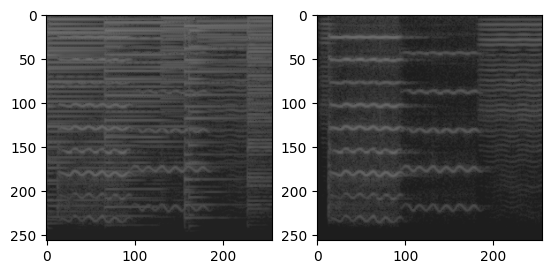

In [3]:
test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=3
                           )

condition, target = test_ds[0]

plt.subplot(1,2,1)
plt.imshow(condition.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(target.permute(1,2,0))

### Model

In [4]:
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
pl_ae_model = Autoencoder(autoencoder).to(device)

In [6]:
ckpt_path = 'trained_models/mask_latent_diffusion/version_1/lighning_logs/checkpoints/epoch=1523-step=48768.ckpt'
model = LatentDiffusionConditional.load_from_checkpoint(ckpt_path, train_dataset = test_ds, autoencoder = pl_ae_model).to(device)


KeyError: 'ipython_dir'

### Evaluation

In [52]:
'''song_num = 3
condition,target=test_ds[song_num]
batch_input=torch.stack(1*[condition],0)


out=model(batch_input, verbose=True)'''

outputs = []
targets = []

for i in range(len(test_ds)):
    out = model(test_ds[i][0], verbose=True)
    masked = out * test_ds[i][0]
    phase = test_ds.get_phase[i]

    audio = test_ds.to_audio(masked, phase)
    outputs.append(audio)
    target = test_ds.to_audio(test_ds[i][1], phase)
    targets.append(target)
    break

print(outputs, targets)

evaluator = ne.BSSEvalScale()



RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [128] and input of shape [128, 256, 256]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

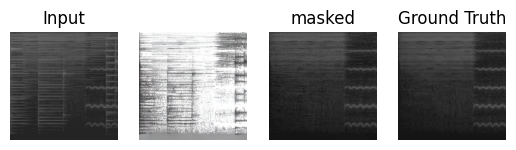

In [25]:
masked = condition * out[0].detach().cpu()

plt.subplot(1,3+len(out),1)
plt.imshow(condition.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,3+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,3+len(out),2+len(out))
plt.imshow(masked.permute(1,2,0))
plt.title('masked')
plt.axis('off')    
plt.subplot(1,3+len(out),3+len(out))
plt.imshow(target.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')